<a href="https://colab.research.google.com/github/Colsai/DATA602_DA_ML/blob/main/DATA602_Project_NBK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA602- FINAL PROJECT (Krishnamoorthy)
## *Chicago Public Schools: Modeling Best Predictors on Graduation Rate using multiple regression models*

### Utilization of Multiple Machine Learning Models to predict school graduation rates based on highly-correlating features.

The purpose of this notebook is to continue an exploration of Chicago Public High Schools, and propose an ML model that can accurately predict a target average of graduation rates for schools. 

Finally, using a model with the highest metric accuracy, I will draw conclusions based on how the model is predicting the quality of the school itself.

In [25]:
!pip install missingno

#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
from IPython.display import clear_output
import sklearn
%matplotlib inline

clear_output()
pd.__version__

'1.1.5'

In [26]:
#Import each dataset (Chicago Public Schools)
start_time = time.time()

df = pd.read_csv("https://data.cityofchicago.org/api/views/dw27-rash/rows.csv?accessType=DOWNLOAD&bom=true&format=true")

dur = time.time()- start_time

print(f"{round(dur,3)}s")

0.781s


## Helper Functions for the Notebook
Some helper functions used in the notebook that are called multiple times.

In [27]:
#Display Function for Variables
def show_all(input_list, line_len = 3):
    """Display custom number of items per columns"""
    num_in_line = 0

    for elem in input_list:
        if num_in_line > line_len - 1:
            print(f"")
            print(elem, end = ', ')
            num_in_line = 0
        
        else:
            print(elem, end = ', ')
        
        num_in_line += 1

#Function to show percent of nulls in col
def show_nulls(df):
    """Show and return number and percent of nulls of data"""
    try:
        return [df.isna().sum(), round(df.isna().sum()/len(df),2)]
    except:
        print("There was an issue with the data")
        return False

#Return Correlations Function
def correlation_return(dataframe_, series_, num = 25):
    """For returning correlations, dataframe_,series_,num returned"""
    corr = dataframe_.corr()
    return (abs(corr[series_]).sort_values(ascending = False)[0:num])

def subtract_lists(list1, list2):
    """Returns a selected list of values of items that are in the first list but not the second"""
    return [item for item in list1 if item not in list2]

## Hypothesis:


# Exploratory Data Analysis of Dataset
- Initial Check through the Data

In [28]:
df.head()

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,...,College_Persistence_School_Pct_Year_2,College_Persistence_CPS_Pct_Year_2,College_Persistence_School_Pct_Year_1,College_Persistence_CPS_Pct_Year_1,Progress_Toward_Graduation_Year_1,Progress_Toward_Graduation_Year_2,State_School_Report_Card_URL,Mobility_Rate_Pct,Chronic_Truancy_Pct,Empty_Progress_Report_Message,School_Survey_Rating_Description,Supportive_School_Award,Supportive_School_Award_Desc,Parent_Survey_Results_Year,School_Latitude,School_Longitude,PSAT_Grade_9_Score_School_Avg,PSAT_Grade_10_Score_School_Avg,SAT_Grade_11_Score_School_Avg,SAT_Grade_11_Score_CPS_Avg,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Grade_9_School_Lbl,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_PSAT_Reading_Grade_10_School_Lbl,Growth_SAT_Grade_11_School_Pct,Growth_SAT_Grade_11_School_Lbl,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_9_School_Lbl,Attainment_PSAT_Grade_10_School_Pct,Attainment_PSAT_Grade_10_School_Lbl,Attainment_SAT_Grade_11_School_Pct,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Pct,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Pct,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Lbl
0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,HS,9652 S MICHIGAN AVE,Chicago,Illinois,"60,628","7,735,355,400","7,735,355,061",http://cps.edu/Schools/Pages/school.aspx?Schoo...,https://www.harlanfalcons.org,"2,018",NaN,NaN,NaN,NaN,NaN,BELOW AVERAGE,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,FAR BELOW EXPECTATIONS,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,PARTIALLY ORGANIZED,Results are based on student and teacher respo...,76.6,81.4,80.0,79.9,41%,35.6,Not Achieved,...,45.5,72.3,56.9,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,33.9,89.4,NaN,This school is “Partially Organized for Improv...,EMERGING,This school has developed an action plan to su...,"2,018",41.718372,-87.620623,701,733,824,969.0,2.0,2nd,32.0,32nd,9.0,9th,8.3,8.3,4.8,4.8,5.6,5.6,6.2,6.2,7.0,7th,50.0,50th,50.0,50th
1,"610,059",MAYER,Oscar Mayer Magnet School,Magnet,ES,2250 N CLIFTON AVE,Chicago,Illinois,"60,614","7,735,345,535","7,735,345,777",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://mayermagnet.org/,"2,018",NaN,NaN,NaN,"2,013",NaN,AVERAGE,Student Growth measures the change in standard...,58.0,58th,47.0,47th,FAR ABOVE AVERAGE,Student Attainment measures how well the schoo...,96.0,96th,91.0,91st,WELL ORGANIZED,Results are based on student and teacher respo...,98.9,81.4,79.1,79.9,> 75%,35.6,Not Achieved,...,NaN,72.3,NaN,71.9,"2,017","2,018",http://iirc.niu.edu/School.aspx?schoolid=15016...,3.8,22.9,NaN,This school is “Well-Organized for Improvement...,EMERGING,This school has developed an action plan to su...,"2,018",41.923204,-87.657287,NaN,NaN,NaN,969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"610,334",RABY HS,Al Raby High Sch

In [29]:
#Introduce the four years' datasets
show_all(df, line_len = 10)

School_ID, Short_Name, Long_Name, School_Type, Primary_Category, Address, City, State, Zip, Phone, 
Fax, CPS_School_Profile, Website, Progress_Report_Year, Blue_Ribbon_Award_Year, Excelerate_Award_Gold_Year, Spot_Light_Award_Year, Improvement_Award_Year, Excellence_Award_Year, Student_Growth_Rating, 
Student_Growth_Description, Growth_Reading_Grades_Tested_Pct_ES, Growth_Reading_Grades_Tested_Label_ES, Growth_Math_Grades_Tested_Pct_ES, Growth_Math_Grades_Tested_Label_ES, Student_Attainment_Rating, Student_Attainment_Description, Attainment_Reading_Pct_ES, Attainment_Reading_Lbl_ES, Attainment_Math_Pct_ES, 
Attainment_Math_Lbl_ES, Culture_Climate_Rating, Culture_Climate_Description, School_Survey_Student_Response_Rate_Pct, School_Survey_Student_Response_Rate_Avg_Pct, School_Survey_Teacher_Response_Rate_Pct, School_Survey_Teacher_Response_Rate_Avg_Pct, School_Survey_Parent_Response_Rate_Pct, School_Survey_Parent_Response_Rate_Avg_Pct, Healthy_School_Certification, 
Healthy_School_Certifi

## Establish the focus of the dataset here (High Schools)
- Our focus here will be to look at only Chicago High Schools- it is difficult to use other types of schools to look at Educational outcomes as we do not really know what they look like. 

In [30]:
#Set High Schools Dataframe for any schools that are high schools
high_schools = df[df['Primary_Category'] == 'HS']

In [31]:
#Dataframe Shape
high_schools.shape

(176, 182)

In [32]:
high_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 647
Columns: 182 entries, School_ID to Growth_SAT_Math_Grade_11_School_Lbl
dtypes: float64(92), object(90)
memory usage: 251.6+ KB


# Data Cleaning and Feature Selection
Our target here will be to analyze graduation rates, so here I will select for
-any graduation-related features that target 'year_2' 
- ('year_2' variables are the most-recent year, and a better indicator for school success)

In [33]:
#What variables here could be selected for a look at graduation rates?
grad_y2 = [col for col in high_schools.columns if ('gradua' in col.lower()) and ('year_2' in col.lower())]
print(grad_y2)

['Graduation_4_Year_School_Pct_Year_2', 'Graduation_4_Year_CPS_Pct_Year_2', 'Graduation_5_Year_School_Pct_Year_2', 'Graduation_5_Year_CPS_Pct_Year_2', 'Progress_Toward_Graduation_Year_2']


In [34]:
high_schools[grad_y2].head(10)

,Graduation_4_Year_School_Pct_Year_2,Graduation_4_Year_CPS_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2,Graduation_5_Year_CPS_Pct_Year_2,Progress_Toward_Graduation_Year_2
0,56.1,75.6,65.7,78.2,"2,018"
2,68.5,75.6,73.1,78.2,"2,018"
9,55.0,75.6,45.5,78.2,"2,018"
10,84.4,75.6,91.2,78.2,"2,018"
17,30.3,75.6,38.3,78.2,"2,018"
19,89.0,75.6,85.7,78.2,"2,018"
27,82.5,75.6,90.7,78.2,"2,018"
33,87.1,75.6,95.5,78.2,"2,018"
37,96.2,75.6,90.6,78.2,"2,018"
41,96.5,75.6,91.8,78.2,"2,018"


From the results, there really are only a few variables here that are of help. 
- Graduation_4_Year_CPS_PCT_Year_2 is just the average of all CPS, as is the 5_year_CPS_PCT_Year_2. 
- Progress_Toward_Graduation_Year_2 is the most-recent year the data was collected.

In [35]:
#For now, let's set our target variable as 4_year_pct and 5_year_pct
target_grad_rate = ['Graduation_4_Year_School_Pct_Year_2', 
                    'Graduation_5_Year_School_Pct_Year_2']

#How many null values are there here?                    
high_schools[target_grad_rate].isna().sum() / len(high_schools)

Graduation_4_Year_School_Pct_Year_2    0.204545
Graduation_5_Year_School_Pct_Year_2    0.238636
dtype: float64

In [36]:
#List cleaned_cols will hold the cols data
cleaned_cols = []

In [37]:
show_nulls(high_schools['Graduation_4_Year_School_Pct_Year_2'])

[36, 0.2]

In [38]:
show_nulls(high_schools['Graduation_5_Year_School_Pct_Year_2'])

[42, 0.24]

In [39]:
#What are the highest correlating factors?
correlation_return(high_schools, 'Graduation_4_Year_School_Pct_Year_2', num = 5)

NWEA_Math_Growth_Grade_4_Pct           1.0
NWEA_Math_Growth_Grade_3_Pct           1.0
Graduation_4_Year_School_Pct_Year_2    1.0
NWEA_Reading_Growth_Grade_4_Pct        1.0
NWEA_Reading_Attainment_Grade_5_Pct    1.0
Name: Graduation_4_Year_School_Pct_Year_2, dtype: float64

In [40]:
pd.DataFrame(high_schools['Graduation_4_Year_CPS_Pct_Year_2'])

,Graduation_4_Year_CPS_Pct_Year_2
0,75.6
2,75.6
9,75.6
10,75.6
17,75.6
...,...
618,75.6
621,75.6
625,75.6
628,75.6


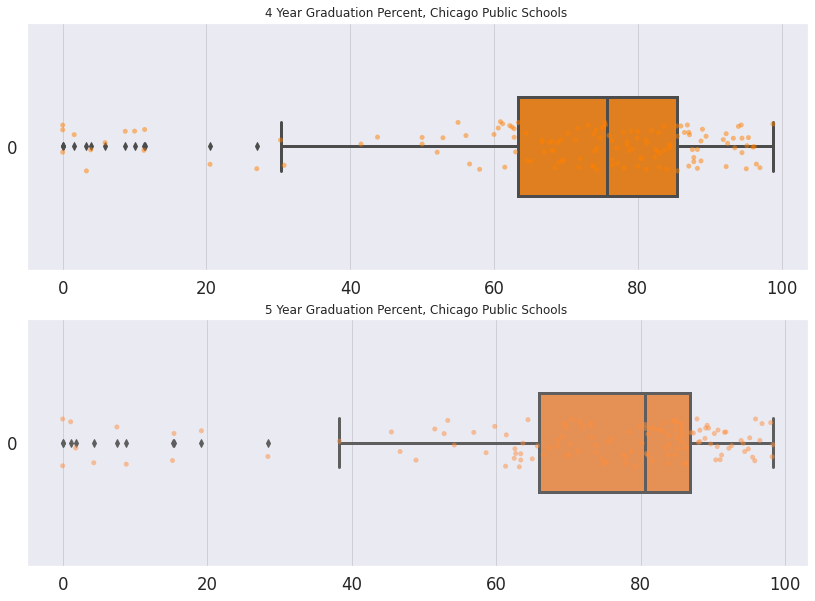

In [41]:
#Visualize the two featurees
fig, ax = plt.subplots(2,1,figsize=(14,10),sharex=False, sharey=False)
sns.set_theme()
sns.set(font_scale= 1.5)

pov_dfs = [high_schools['Graduation_4_Year_School_Pct_Year_2'],high_schools['Graduation_5_Year_School_Pct_Year_2']]
pov_titles = ['4 Year Graduation Percent', '5 Year Graduation Percent']
colors = ['autumn_r', 'Oranges_r']
for i in range(0,2):
    ax[i].set_title(f"{pov_titles[i]}, Chicago Public Schools ", size = 12)
    ax[i].grid(color='gray', alpha = .5, linestyle='-', linewidth=.5)
    
    sns.boxplot(
                data = pov_dfs[i],
                width = .4,
                linewidth = 3,
                palette =  colors[i],
                ax = ax[i],
                orient = "h")

    sns.stripplot(
                alpha = .5, 
                data = pov_dfs[i],
                palette = colors[i],
                ax = ax[i],
                orient = "h")

Naturally, the graduation rate for 5 years is higher and has a lower standard deviation than the graduation rate for 4 year graduation percent.

Frighteningly, some of the graduation rates here for Chicago Public Schools are at 0 or very near 0.

In [42]:
high_schools['Graduation_4_Year_School_Pct_Year_2'].value_counts(bins = 5, sort = False)

(-0.0998, 19.76]    11
(19.76, 39.52]       4
(39.52, 59.28]      10
(59.28, 79.04]      56
(79.04, 98.8]       59
Name: Graduation_4_Year_School_Pct_Year_2, dtype: int64

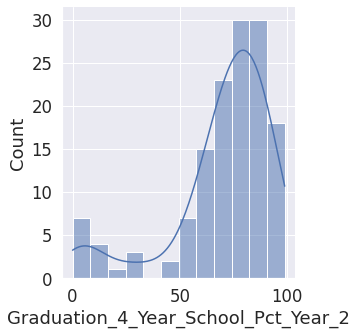

In [43]:
#Graphing the Distribution of Graduation Scores
sns.displot(high_schools['Graduation_4_Year_School_Pct_Year_2'], kde = True)

In [44]:
high_schools['Graduation_5_Year_School_Pct_Year_2'].value_counts(bins = 5, sort = False)

(-0.0993, 19.66]    10
(19.66, 39.32]       2
(39.32, 58.98]       9
(58.98, 78.64]      41
(78.64, 98.3]       72
Name: Graduation_5_Year_School_Pct_Year_2, dtype: int64

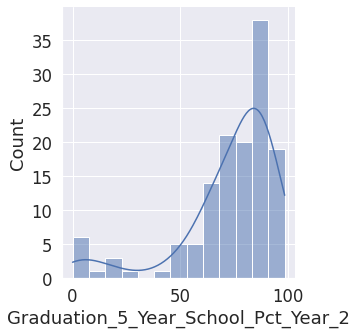

In [45]:
#Graphing the Distribution of Graduation Scores
sns.displot(high_schools['Graduation_5_Year_School_Pct_Year_2'], kde = True)

In [46]:
high_schools[['Short_Name', 'Graduation_4_Year_School_Pct_Year_2', 'Graduation_5_Year_School_Pct_Year_2']].sort_values(by = 'Graduation_4_Year_School_Pct_Year_2', ascending = True)

,Short_Name,Graduation_4_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2
402,NORTHSIDE LEARNING HS,0.0,0.0
601,VAUGHN HS,0.0,19.2
100,CAMELOT - EXCEL SOUTHWEST HS,0.0,NaN
609,YORK HS,1.6,1.1
177,OMBUDSMAN - SOUTH HS,3.3,NaN
...,...,...,...
593,PEACE AND EDUCATION HS,NaN,NaN
607,SOUTHSIDE HS,NaN,NaN
621,YCCS - VIRTUAL,NaN,NaN
628,YCCS - OLIVE HARVEY,NaN,NaN


## Analysis:
'York High School', one of the lowest-ranking high schools in Chicago Public Schools, has a very low graduation rate0 1.6. Somehow, it has an even lower rate for 5 year graduation rate. These issues are reflected in extra information on school performance.

https://www.publicschoolreview.com/york-alternative-high-school-profile

## What this suggests:
This school performance indicates obvious school issues that are affecting performance. In the next section, feature selection, I will look to identify which features those are, and finally look to create a model, analyze model performance, and draw summary conclusions based on what I see.


## Data Cleaning and Feature Selection
Removing some useless or unhelpful columns
- year_2 values are values for the most-recent year. 
- Since those numbers are more relevant than year_1 (the previous year's) numbers, we'll keep those

In [47]:
high_schools.columns[4:13]

Index(['Primary_Category', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax',
       'CPS_School_Profile', 'Website'],
      dtype='object')

### Removing Data:
- Explaining the removal of data columns here:
Categorical Desc Cols: This removes several categorical variables that will not be used (address, etc.)

- High Null Cols: This removes any columns that do not have at least 75% of the data present as nulls (for any items that have nulls -- some data in other columns is also entered as 'NO DATA AVAILABLE', etc.)

- Description Cols: Description Cols serve to explain a type of feature, but are not helpful for the actual analysis here. They'll be removed.

- Years Cols: The dataset contains values from both this and last year. We'll only want to look at the most recent data here, any data that is 'year_2'. We'll skip the year_1 data.

- Label Data: Label Cols are also columns that have descriptive data that is not helpful for the dataset here. 

In [48]:
#Create lists of columns for removal
categorical_desc_cols = high_schools.columns[4:13] #Remove some categorical data here

 #Remove any items with nulls higher than 75%
high_null_cols = [col for col in high_schools if high_schools[col].isna().sum()/len(high_schools) >= .75]

#Remove other categorical columns
description_cols = [col for col in high_schools.columns if "description" in col.lower() or "avg" in col.lower() or "cps_pct_year" in col.lower()] #Remove anything with 'description' in title, not useful here
label_cols = [col for col in high_schools.columns if "lbl" in col.lower()]
more_unused_cols = ['Address', 'City', 'State', 'Zip', 'Phone', 'Fax', 'Website', 'Progress_Report_Year', 'State_School_Report_Card_URL', 'CPS_School_Profile', 'School_Latitude','School_Longitude', 'Other_Metrics_Year_1', 'Other_Metrics_Year_2']

#Remove ALL Year Columns. Then KEEP year values, but drop any values that are cps_pct_year, since they are only averages of the column
all_year_cols = [col for col in high_schools.columns if "year" in col.lower()]
year_1_cols = [col for col in high_schools.columns if ("year_1" in col.lower() and 'cps_pct_year_1' not in col.lower())]
year_2_cols = [col for col in high_schools.columns if ("year_2" in col.lower() and 'cps_pct_year_2' not in col.lower())]

#Combine all columns
all_cols = description_cols + [categorical_desc_cols[0]] + high_null_cols + all_year_cols + label_cols + more_unused_cols

#Set Modified Cols Here
temp_cols = [col for col in list(high_schools.columns) if col not in all_cols] + year_2_cols

In [49]:
len(temp_cols)

49

In [50]:
high_schools[temp_cols].head(1).T[0::]

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED
School_Survey_Student_Response_Rate_Pct,76.6
School_Survey_Teacher_Response_Rate_Pct,80
School_Survey_Parent_Response_Rate_Pct,41%


In [51]:
show_all(high_schools[temp_cols].columns)

School_ID, Short_Name, Long_Name, 
School_Type, Student_Growth_Rating, Student_Attainment_Rating, 
Culture_Climate_Rating, School_Survey_Student_Response_Rate_Pct, School_Survey_Teacher_Response_Rate_Pct, 
School_Survey_Parent_Response_Rate_Pct, Healthy_School_Certification, Creative_School_Certification, 
School_Survey_Involved_Families, School_Survey_Supportive_Environment, School_Survey_Ambitious_Instruction, 
School_Survey_Effective_Leaders, School_Survey_Collaborative_Teachers, School_Survey_Safety, 
School_Survey_School_Community, School_Survey_Parent_Teacher_Partnership, School_Survey_Quality_Of_Facilities, 
Mobility_Rate_Pct, Chronic_Truancy_Pct, Supportive_School_Award, 
Supportive_School_Award_Desc, Growth_PSAT_Grade_9_School_Pct, Growth_PSAT_Reading_Grade_10_School_Pct, 
Growth_SAT_Grade_11_School_Pct, Attainment_PSAT_Grade_9_School_Pct, Attainment_PSAT_Grade_10_School_Pct, 
Attainment_SAT_Grade_11_School_Pct, Attainment_All_Grades_School_Pct, Growth_PSAT_Math_Grade_10_Schoo

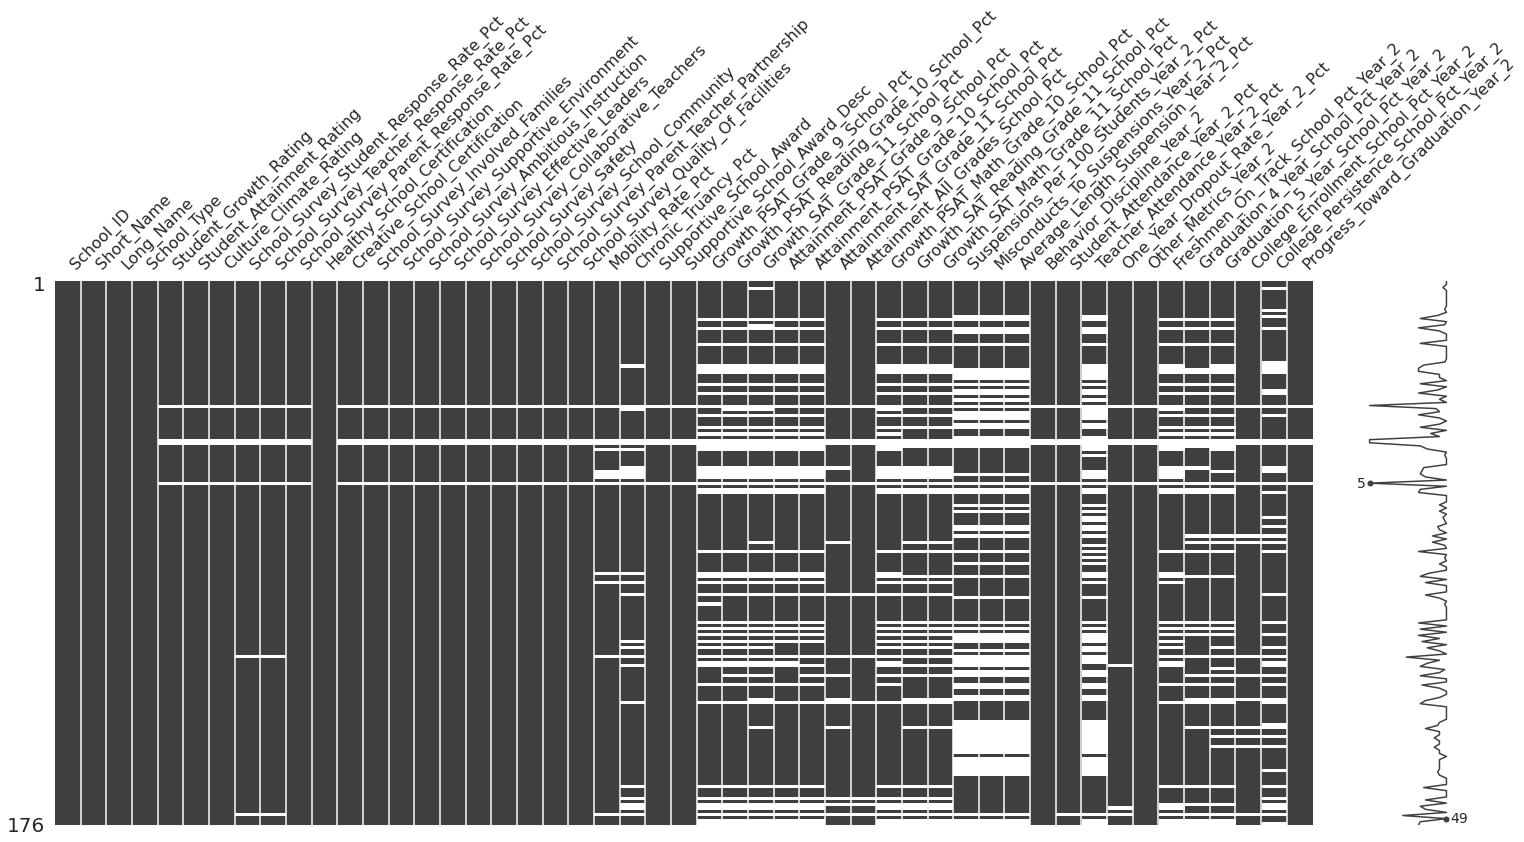

In [52]:
#Visualizing the number of nulls here
msno.matrix(high_schools[temp_cols])

In [53]:
high_schools[temp_cols].head(1).T[0::]

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED
School_Survey_Student_Response_Rate_Pct,76.6
School_Survey_Teacher_Response_Rate_Pct,80
School_Survey_Parent_Response_Rate_Pct,41%


In [54]:
high_schools[temp_cols].head(1).T[35:70]

,0
Suspensions_Per_100_Students_Year_2_Pct,38.8
Misconducts_To_Suspensions_Year_2_Pct,22.5
Average_Length_Suspension_Year_2_Pct,2.1 days
Behavior_Discipline_Year_2,"2,017"
Student_Attendance_Year_2_Pct,83.2
Teacher_Attendance_Year_2_Pct,93.3
One_Year_Dropout_Rate_Year_2_Pct,9.9
Other_Metrics_Year_2,"2,018"
Freshmen_On_Track_School_Pct_Year_2,68.8
Graduation_4_Year_School_Pct_Year_2,56.1


# Change the 'Average_Length_Suspension' column
This column has day values, but contains string objects '# DAY', rather than float values. We'll convert this into numerical values for teh data. 

In [55]:
high_schools['Average_Length_Suspension_Year_2_Pct'].dtypes

dtype('O')

In [56]:
high_schools['Average_Length_Suspension_Year_2_Pct'].fillna("0 days")

0      2.1 days
2      2.0 days
9      2.5 days
10     2.0 days
17     2.2 days
         ...   
618    2.2 days
621      0 days
625    2.5 days
628      0 days
647      0 days
Name: Average_Length_Suspension_Year_2_Pct, Length: 176, dtype: object

In [57]:
#Impute Days column as nonnan first, then impute all other values as the mean.
try:
  avg_len_numerical = [float(elem.split()[0]) if pd.notnull(elem) == True else elem for elem in high_schools['Average_Length_Suspension_Year_2_Pct']]
except:
  print("Error")

cleaned_col = pd.Series(avg_len_numerical).fillna(value = np.mean(np.nanmean(avg_len_numerical)))

#Reset Index and Add Values Into The Dataframe
high_schools.reset_index(drop = True, inplace = True)
high_schools['Average_Length_Suspension_Year_2_Pct'] = cleaned_col

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [58]:
#One Hot Encode School Type
pd.get_dummies(high_schools['School_Type'], prefix = '', prefix_sep= "")

,Career academy,Charter,Citywide-Option,Contract,Magnet,Military academy,Neighborhood,Selective enrollment,Small,Special Education
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
171,0,0,0,0,0,0,0,0,1,0
172,0,1,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,1,0,0,0
174,0,1,0,0,0,0,0,0,0,0


In [59]:
high_schools[temp_cols].head(2).T

,0,1
School_ID,"609,710","610,334"
Short_Name,HARLAN HS,RABY HS
Long_Name,John M Harlan Community Academy High School,Al Raby High School
School_Type,Neighborhood,Small
Student_Growth_Rating,BELOW AVERAGE,BELOW AVERAGE
Student_Attainment_Rating,FAR BELOW EXPECTATIONS,FAR BELOW EXPECTATIONS
Culture_Climate_Rating,PARTIALLY ORGANIZED,WELL ORGANIZED
School_Survey_Student_Response_Rate_Pct,76.6,74.1
School_Survey_Teacher_Response_Rate_Pct,80,76.9
School_Survey_Parent_Response_Rate_Pct,41%,< 30%


In [60]:
high_schools[temp_cols].info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Columns: 49 entries, School_ID to Progress_Toward_Graduation_Year_2
dtypes: float64(25), object(24)
memory usage: 67.5+ KB


#Converting and imputing ordinal data
There are two main challenges for imputing and converting categorical data into numerical data. 
- Student_Growth_Rating, Student_Attainment_Rating, Culture_Climate_Rating, Supportive_School_Award, Healthy_School_Certification
- Survey Data (any col with 'survey' in it)

In [61]:
#Since these 
cat_data_cols = ['Student_Growth_Rating', 
                'Student_Attainment_Rating', 
                'Culture_Climate_Rating', 
                'Supportive_School_Award', 
                'Healthy_School_Certification']

for col in cat_data_cols:
    print(high_schools[col].value_counts(normalize = True, sort = True))

AVERAGE              0.470930
NO DATA AVAILABLE    0.209302
BELOW AVERAGE        0.191860
ABOVE AVERAGE        0.110465
FAR ABOVE AVERAGE    0.017442
Name: Student_Growth_Rating, dtype: float64
FAR BELOW EXPECTATIONS    0.529070
BELOW EXPECTATIONS        0.186047
MET EXPECTATIONS          0.133721
ABOVE EXPECTATIONS        0.069767
FAR ABOVE EXPECTATIONS    0.046512
NO DATA AVAILABLE         0.034884
Name: Student_Attainment_Rating, dtype: float64
WELL ORGANIZED          0.494186
ORGANIZED               0.273256
PARTIALLY ORGANIZED     0.127907
MODERATELY ORGANIZED    0.040698
NOT ENOUGH DATA         0.034884
NOT YET ORGANIZED       0.029070
Name: Culture_Climate_Rating, dtype: float64
NOT RATED      0.500000
EMERGING       0.302326
ESTABLISHED    0.151163
EXEMPLARY      0.046512
Name: Supportive_School_Award, dtype: float64
Not Achieved    1.0
Name: Healthy_School_Certification, dtype: float64


**Note:** Here, we can immediately remove 'Supportive_School_Award', since NONE of the schools have achieved the ranking. Additionally, Culture_Climate_Rating does not appear to have enough data to meet our 75% criteria for choosing data - 50% of the schools have not been rated.

In [62]:
#Subtract these cols From temp_cols
temp_cols = subtract_lists(temp_cols, ['Healthy_School_Certification', 'Supportive_School_Award'])
len(temp_cols)

47

In [63]:
cat_data_cols_checked = ['Student_Growth_Rating', 'Student_Attainment_Rating', 'Culture_Climate_Rating']

In [64]:
#What are the possible values?
high_schools['Student_Growth_Rating'].value_counts()

AVERAGE              81
NO DATA AVAILABLE    36
BELOW AVERAGE        33
ABOVE AVERAGE        19
FAR ABOVE AVERAGE     3
Name: Student_Growth_Rating, dtype: int64

In [65]:
#Because these values are ordinal (there is an order to them, and I want to retain that order, I'll write a custom imputation function here)
def convert_ordinal_to_numerical(df_, impute_nulls = True):
    """This takes nominal categorical data and transforms it into a numerical value"""
    numerical_scores = []

    for val in list(df_):
        if val == 'FAR ABOVE AVERAGE' or val == 'FAR ABOVE EXPECTATIONS' or val == 'WELL ORGANIZED':
            numerical_scores.append(5)
        elif val == 'ABOVE AVERAGE' or val == 'ABOVE EXPECTATIONS' or val == 'ORGANIZED':
            numerical_scores.append(4)
        elif val == 'AVERAGE' or val == 'MET EXPECTATIONS' or val == 'MODERATELY ORGANIZED':
            numerical_scores.append(3)
        elif val == 'BELOW AVERAGE' or 'BELOW EXPECATATIONS' or val == 'PARTIALLY ORGANIZED':
            numerical_scores.append(2)
        elif val == 'FAR BELOW AVERAGE' or ' FAR BELOW EXPECTATIONS' or val == 'NOT YET ORGANIZED':
            numerical_scores.append(1)
        #I'll impute any missing values as average
        else: numerical_scores.append(np.nan)
    
    score_mean = round(np.nanmean(np.array(numerical_scores)),2)
    scores_arry = np.array(numerical_scores)

    if impute_nulls == True:    
        return np.nan_to_num(scores_arry, nan = score_mean)

    else:
        return scores_arry

In [66]:
high_schools['Student_Growth_Rating']

0          BELOW AVERAGE
1          BELOW AVERAGE
2          BELOW AVERAGE
3                AVERAGE
4          BELOW AVERAGE
             ...        
171              AVERAGE
172    NO DATA AVAILABLE
173              AVERAGE
174    NO DATA AVAILABLE
175    NO DATA AVAILABLE
Name: Student_Growth_Rating, Length: 176, dtype: object

In [67]:
high_schools['Student_Growth_Rating'] = convert_ordinal_to_numerical(high_schools['Student_Growth_Rating'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
high_schools['Student_Attainment_Rating'].value_counts()

FAR BELOW EXPECTATIONS    91
BELOW EXPECTATIONS        32
MET EXPECTATIONS          23
ABOVE EXPECTATIONS        12
FAR ABOVE EXPECTATIONS     8
NO DATA AVAILABLE          6
Name: Student_Attainment_Rating, dtype: int64

In [69]:
high_schools['Student_Attainment_Rating'] = convert_ordinal_to_numerical(high_schools['Student_Attainment_Rating'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
high_schools['Culture_Climate_Rating'].value_counts()

WELL ORGANIZED          85
ORGANIZED               47
PARTIALLY ORGANIZED     22
MODERATELY ORGANIZED     7
NOT ENOUGH DATA          6
NOT YET ORGANIZED        5
Name: Culture_Climate_Rating, dtype: int64

In [71]:
high_schools['Culture_Climate_Rating'] = convert_ordinal_to_numerical(high_schools['Culture_Climate_Rating'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Those columns are now successfully converted and imputed

In [72]:
high_schools[temp_cols].select_dtypes(include=['object']).columns

Index(['School_ID', 'Short_Name', 'Long_Name', 'School_Type',
       'School_Survey_Parent_Response_Rate_Pct',
       'Creative_School_Certification', 'School_Survey_Involved_Families',
       'School_Survey_Supportive_Environment',
       'School_Survey_Ambitious_Instruction',
       'School_Survey_Effective_Leaders',
       'School_Survey_Collaborative_Teachers', 'School_Survey_Safety',
       'School_Survey_School_Community',
       'School_Survey_Parent_Teacher_Partnership',
       'School_Survey_Quality_Of_Facilities', 'Supportive_School_Award_Desc',
       'Behavior_Discipline_Year_2', 'Other_Metrics_Year_2',
       'Progress_Toward_Graduation_Year_2'],
      dtype='object')

In [73]:
high_schools[temp_cols].select_dtypes(include=['object']).head(1).T

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
School_Survey_Parent_Response_Rate_Pct,41%
Creative_School_Certification,STRONG
School_Survey_Involved_Families,WEAK
School_Survey_Supportive_Environment,NEUTRAL
School_Survey_Ambitious_Instruction,STRONG
School_Survey_Effective_Leaders,WEAK


In [74]:
#Remove Cols
remove_more_cols = ['Behavior_Discipline_Year_2', 
                    'Other_Metrics_Year_2', 
                    'Progress_Toward_Graduation_Year_2']

Several of these columns can be dropped- behavior discipline year, other_metrics_year, progress_toward_graduation_year_2. 

- Average_Length_Suspension_Year_2_Pct and  needs to be converted.

In [75]:
high_schools[temp_cols].select_dtypes(include=['float64']).columns

Index(['School_Survey_Student_Response_Rate_Pct',
       'School_Survey_Teacher_Response_Rate_Pct', 'Mobility_Rate_Pct',
       'Chronic_Truancy_Pct', 'Growth_PSAT_Grade_9_School_Pct',
       'Growth_PSAT_Reading_Grade_10_School_Pct',
       'Growth_SAT_Grade_11_School_Pct', 'Attainment_PSAT_Grade_9_School_Pct',
       'Attainment_PSAT_Grade_10_School_Pct',
       'Attainment_SAT_Grade_11_School_Pct',
       'Attainment_All_Grades_School_Pct',
       'Growth_PSAT_Math_Grade_10_School_Pct',
       'Growth_SAT_Reading_Grade_11_School_Pct',
       'Growth_SAT_Math_Grade_11_School_Pct',
       'Suspensions_Per_100_Students_Year_2_Pct',
       'Misconducts_To_Suspensions_Year_2_Pct',
       'Average_Length_Suspension_Year_2_Pct', 'Student_Attendance_Year_2_Pct',
       'Teacher_Attendance_Year_2_Pct', 'One_Year_Dropout_Rate_Year_2_Pct',
       'Freshmen_On_Track_School_Pct_Year_2',
       'Graduation_4_Year_School_Pct_Year_2',
       'Graduation_5_Year_School_Pct_Year_2',
       'College_En

## Converting and Imputing Survey Data
Several of the variables here are variables that are categorical, which will need to be converted. 

In [76]:
#High School Survey Columns
hs_survey_cols = [col for col in high_schools[temp_cols].columns if "School_Survey" in col][3:]
high_schools[hs_survey_cols][3:].value_counts()

School_Survey_Involved_Families  School_Survey_Supportive_Environment  School_Survey_Ambitious_Instruction  School_Survey_Effective_Leaders  School_Survey_Collaborative_Teachers  School_Survey_Safety  School_Survey_School_Community  School_Survey_Parent_Teacher_Partnership  School_Survey_Quality_Of_Facilities
NOT ENOUGH DATA                  NOT ENOUGH DATA                       NOT ENOUGH DATA                      NOT ENOUGH DATA                  NOT ENOUGH DATA                       NOT ENOUGH DATA       NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT ENOUGH DATA                        6
NEUTRAL                          NEUTRAL                               STRONG                               NEUTRAL                          NEUTRAL                               WEAK                  NOT ENOUGH DATA                 NOT ENOUGH DATA                           NOT ENOUGH DATA                        5
                                                         

Let's look at this a little more closely...

In [77]:
look_cols = [col for col in high_schools[temp_cols].columns if "School_Survey" in col][3:]
for col in look_cols:
    print(high_schools[col].value_counts())

NEUTRAL            54
STRONG             46
VERY STRONG        33
NOT ENOUGH DATA    20
WEAK               17
VERY WEAK           2
Name: School_Survey_Involved_Families, dtype: int64
NEUTRAL            75
STRONG             68
VERY STRONG        11
NOT ENOUGH DATA    10
WEAK                7
VERY WEAK           1
Name: School_Survey_Supportive_Environment, dtype: int64
STRONG             74
VERY STRONG        63
NEUTRAL            22
NOT ENOUGH DATA    10
WEAK                3
Name: School_Survey_Ambitious_Instruction, dtype: int64
NEUTRAL            69
STRONG             48
WEAK               28
NOT ENOUGH DATA    15
VERY STRONG         8
VERY WEAK           4
Name: School_Survey_Effective_Leaders, dtype: int64
STRONG             65
NEUTRAL            52
VERY STRONG        23
WEAK               17
NOT ENOUGH DATA    14
VERY WEAK           1
Name: School_Survey_Collaborative_Teachers, dtype: int64
WEAK               108
NEUTRAL             26
VERY WEAK           21
NOT ENOUGH DATA    

## Transforming and imputing survey data
Looking at the data here, several columns appear to not have enough data to proceed. We'll drop them here. Setting a threshold of 10% or less of 'NOT ENOUGH DATA' (missing values here), we'll check.

In [78]:
#Checking that function works
len(high_schools['School_Survey_Parent_Teacher_Partnership'][high_schools['School_Survey_Parent_Teacher_Partnership'] == 'NOT ENOUGH DATA'])/len(high_schools)

0.7386363636363636

In [79]:
#Return the number of columns that the percent of nulls is less than 20% of all data
thresh = .1
survey_enough_data = [col for col in look_cols if len(high_schools[col][high_schools[col] == 'NOT ENOUGH DATA'])/len(high_schools) <= thresh]
survey_enough_data

['School_Survey_Supportive_Environment',
 'School_Survey_Ambitious_Instruction',
 'School_Survey_Effective_Leaders',
 'School_Survey_Collaborative_Teachers',
 'School_Survey_Safety']

In [80]:
#Because these values are ordinal (there is an order to them, and I want to retain that order, I'll write a custom imputation function here)
def to_numerical_scores(df_, impute_nulls = True):
    """This takes nominal categorical data and transforms it into a numerical value"""
    numerical_scores = []

    for val in list(df_):
        if val == 'VERY STRONG':
            numerical_scores.append(5)
        elif val == 'STRONG':
            numerical_scores.append(4)
        elif val == 'NEUTRAL':
            numerical_scores.append(3)
        elif val == 'WEAK':
            numerical_scores.append(2)
        elif val == 'VERY WEAK':
            numerical_scores.append(1)
        #I'll impute any missing values as average
        else: numerical_scores.append(np.nan)
    
    score_mean = round(np.nanmean(np.array(numerical_scores)),2)
    scores_arry = np.array(numerical_scores)

    if impute_nulls == True:    
        return np.nan_to_num(scores_arry, nan = score_mean)

    else:
        return scores_arry

In [81]:
to_numerical_scores(high_schools['School_Survey_Safety'], True)

array([2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 2.  ,
       3.  , 2.  , 2.  , 2.  , 2.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 2.  , 2.  , 2.  , 3.  , 2.12, 2.  , 2.  , 1.  , 2.12,
       2.12, 4.  , 2.  , 2.  , 2.  , 2.  , 1.  , 2.12, 2.  , 3.  , 2.  ,
       1.  , 1.  , 2.  , 4.  , 2.  , 3.  , 2.  , 2.12, 2.12, 2.  , 2.  ,
       2.  , 2.  , 2.  , 1.  , 2.  , 2.  , 3.  , 3.  , 3.  , 4.  , 2.12,
       2.  , 2.12, 2.  , 1.  , 1.  , 2.  , 1.  , 2.  , 3.  , 2.  , 2.  ,
       3.  , 2.  , 2.  , 2.  , 2.  , 2.  , 4.  , 2.  , 2.  , 2.  , 2.  ,
       1.  , 2.  , 2.  , 2.  , 3.  , 2.  , 3.  , 2.  , 1.  , 2.  , 1.  ,
       3.  , 2.  , 5.  , 2.  , 2.  , 2.  , 2.  , 3.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 3.  , 2.  , 2.  , 2.  , 4.  , 3.  , 2.12, 1.  , 2.  ,
       2.12, 2.12, 3.  , 2.  , 2.  , 1.  , 1.  , 2.  , 2.  , 2.  , 2.  ,
       2.  , 2.  , 1.  , 1.  , 4.  , 2.  , 2.  , 3.  , 2.  , 2.  , 1.  ,
       2.  , 3.  , 2.  , 2.  , 2.  , 2.  , 1.  , 3.

In [82]:
#Impute values
try:
    survey_involved_family_num = to_numerical_scores(high_schools.School_Survey_Involved_Families, True)
    survey_ambitious_inst_num = to_numerical_scores(high_schools.School_Survey_Ambitious_Instruction, True)
    survey_effective_leaders_num = to_numerical_scores(high_schools.School_Survey_Effective_Leaders, True)
    survey_collab_teachers_num = to_numerical_scores(high_schools.School_Survey_Collaborative_Teachers, True)
    survey_safety_num = to_numerical_scores(high_schools.School_Survey_Safety, True)

except:
    print("Issue in attempt-did not fully execute")

finally:
    survey_numerical_converted = [survey_involved_family_num, survey_ambitious_inst_num, survey_effective_leaders_num, survey_collab_teachers_num, survey_safety_num]

In [ ]:
temp_cols

In [144]:
#Rename Data
df_survey_numerical = pd.DataFrame(survey_numerical_converted).T
df_survey_numerical.rename(columns = {0:'survey_involved_family_num',
                                      1:'survey_ambitious_inst_num', 
                                      2:'survey_effective_leaders_num',
                                      3:'survey_collab_teachers_num', 
                                      4:'survey_safety_num'}, inplace = True)

In [84]:
df_survey_numerical

,survey_involved_family_num,survey_ambitious_inst_num,survey_effective_leaders_num,survey_collab_teachers_num,survey_safety_num
0,2.0,4.00,2.00,2.00,2.00
1,3.0,4.00,4.00,4.00,2.00
2,3.0,4.00,3.00,3.00,3.00
3,4.0,5.00,4.00,5.00,2.00
4,4.0,5.00,4.00,4.00,2.00
...,...,...,...,...,...
171,4.0,5.00,4.00,5.00,1.00
172,3.6,4.22,3.18,3.58,2.12
173,5.0,5.00,3.00,4.00,3.00
174,3.6,4.00,3.00,3.00,2.00


In [85]:
high_schools.reset_index(inplace=True, drop = True)

In [86]:
high_schools[[0,1,2,3,4]] = df_survey_numerical

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Handling other ordinal data

In [87]:
high_schools[temp_cols].head(1).T

,0
School_ID,"609,710"
Short_Name,HARLAN HS
Long_Name,John M Harlan Community Academy High School
School_Type,Neighborhood
Student_Growth_Rating,2
Student_Attainment_Rating,2
Culture_Climate_Rating,2
School_Survey_Student_Response_Rate_Pct,76.6
School_Survey_Teacher_Response_Rate_Pct,80
School_Survey_Parent_Response_Rate_Pct,41%


In [88]:
high_schools['Student_Growth_Rating'].value_counts()

3    81
2    73
4    19
5     3
Name: Student_Growth_Rating, dtype: int64

In [89]:
high_schools['Student_Attainment_Rating'].value_counts()

2    133
3     23
4     12
5      8
Name: Student_Attainment_Rating, dtype: int64

In [90]:
high_schools['Culture_Climate_Rating'].value_counts()

5    85
4    47
2    37
3     7
Name: Culture_Climate_Rating, dtype: int64

In [91]:
num_col_names = [elem + '_Num' for elem in hs_survey_cols]

In [92]:
#Set and establish new values from lists heres
for col in range(0,len(num_col_names)):
    num_col_names[0] = [num_col_names[0], ]

In [93]:
num_col_names

[[[[[[[[[['School_Survey_Involved_Families_Num']]]]]]]]],
 'School_Survey_Supportive_Environment_Num',
 'School_Survey_Ambitious_Instruction_Num',
 'School_Survey_Effective_Leaders_Num',
 'School_Survey_Collaborative_Teachers_Num',
 'School_Survey_Safety_Num',
 'School_Survey_School_Community_Num',
 'School_Survey_Parent_Teacher_Partnership_Num',
 'School_Survey_Quality_Of_Facilities_Num']

In [94]:
high_schools[temp_cols]['Student_Growth_Rating'].value_counts()

3    81
2    73
4    19
5     3
Name: Student_Growth_Rating, dtype: int64

In [95]:
high_schools['School_Type'].value_counts()

Charter                 65
Neighborhood            46
Citywide-Option         18
Small                   13
Selective enrollment    11
Magnet                   7
Military academy         6
Career academy           4
Special Education        4
Contract                 2
Name: School_Type, dtype: int64

This function selects, generates, and visualizes x figures which correlate y% to the target value.

In [96]:
show_all(temp_cols,4)

School_ID, Short_Name, Long_Name, School_Type, 
Student_Growth_Rating, Student_Attainment_Rating, Culture_Climate_Rating, School_Survey_Student_Response_Rate_Pct, 
School_Survey_Teacher_Response_Rate_Pct, School_Survey_Parent_Response_Rate_Pct, Creative_School_Certification, School_Survey_Involved_Families, 
School_Survey_Supportive_Environment, School_Survey_Ambitious_Instruction, School_Survey_Effective_Leaders, School_Survey_Collaborative_Teachers, 
School_Survey_Safety, School_Survey_School_Community, School_Survey_Parent_Teacher_Partnership, School_Survey_Quality_Of_Facilities, 
Mobility_Rate_Pct, Chronic_Truancy_Pct, Supportive_School_Award_Desc, Growth_PSAT_Grade_9_School_Pct, 
Growth_PSAT_Reading_Grade_10_School_Pct, Growth_SAT_Grade_11_School_Pct, Attainment_PSAT_Grade_9_School_Pct, Attainment_PSAT_Grade_10_School_Pct, 
Attainment_SAT_Grade_11_School_Pct, Attainment_All_Grades_School_Pct, Growth_PSAT_Math_Grade_10_School_Pct, Growth_SAT_Reading_Grade_11_School_Pct, 
Growth_SAT

In [97]:
high_schools[temp_cols].corr()

,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,School_Survey_Student_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Pct,Mobility_Rate_Pct,Chronic_Truancy_Pct,Growth_PSAT_Grade_9_School_Pct,Growth_PSAT_Reading_Grade_10_School_Pct,Growth_SAT_Grade_11_School_Pct,Attainment_PSAT_Grade_9_School_Pct,Attainment_PSAT_Grade_10_School_Pct,Attainment_SAT_Grade_11_School_Pct,Attainment_All_Grades_School_Pct,Growth_PSAT_Math_Grade_10_School_Pct,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Student_Attendance_Year_2_Pct,Teacher_Attendance_Year_2_Pct,One_Year_Dropout_Rate_Year_2_Pct,Freshmen_On_Track_School_Pct_Year_2,Graduation_4_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_2,College_Enrollment_School_Pct_Year_2,College_Persistence_School_Pct_Year_2
Student_Growth_Rating,1.000000,0.405678,0.379809,0.206471,0.180897,-0.564403,-0.546487,0.698386,0.419090,0.790291,0.418451,0.504967,0.565559,0.581040,0.631565,0.210338,0.541227,-0.334154,-0.048044,-0.053708,0.540999,0.377932,-0.480357,0.021894,0.420074,0.472417,0.651509,0.495142
Student_Attainment_Rating,0.405678,1.000000,0.298161,0.165540,-0.122686,-0.393078,-0.451539,0.589813,-0.037957,0.499262,0.903570,0.894435,0.919309,0.911646,0.046929,0.031994,0.185965,-0.357907,0.029174,-0.096322,0.377910,0.282159,-0.322651,0.346252,0.451955,0.451500,0.528841,0.591767
Culture_Climate_Rating,0.379809,0.298161,1.000000,0.261210,0.196749,-0.254279,-0.308913,0.308057,0.067637,0.295895,0.243459,0.240017,0.317488,0.311514,0.112520,0.170875,0.190919,-0.050423,0.166775,0.024144,0.379557,0.175257,-0.302291,0.231763,0.149709,0.158260,0.198664,0.242012
School_Survey_Student_Response_Rate_Pct,0.206471,0.165540,0.261210,1.000000,0.388126,-0.280253,-0.404533,0.198777,-0.239463,0.113826,0.169765,0.135353,0.231032,0.224831,-0.091537,0.060847,-0.037561,-0.061114,0.031147,0.008038,0.348766,0.275232,-0.318970,0.250675,0.170005,0.139585,0.285195,0.213442
School_Survey_Teacher_Response_Rate_Pct,0.180897,-0.122686,0.196749,0.388126,1.000000,-0.061233,-0.095373,0.102932,0.124135,0.126530,-0.114906,-0.123318,-0.089572,-0.095264,0.092199,-0.023908,0.094260,0.169485,0.104517,0.054177,-0.002744,0.121444,0.053229,0.028864,-0.142543,-0.167973,-0.006749,-0.093038
Mobility_Rate_Pct,-0.564403,-0.393078,-0.254279,-0.280253,-0.061233,1.000000,0.921225,-0.640656,-0.025588,-0.505207,-0.647776,-0.617282,-0.548251,-0.600179,-0.155854,-0.021056,-0.198946,0.262779,-0.126273,-0.043054,-0.847387,-0.378687,0.947524,-0.429117,-0.794253,-0.819511,-0.814237,-0.676788
Chronic_Truancy_Pct,-0.546487,-0.451539,-0.308913,-0.404533,-0.095373,0.921225,1.000000,-0.648868,-0.017869,-0.554008,-0.676319,-0.645535,-0.612067,-0.647652,-0.141783,0.002456,-0.169710,0.618375,-0.088152,0.074186,-0.906989,-0.453415,0.887752,-0.375992,-0.713193,-0.793656,-0.847657,-0.704633
Growth_PSAT_Grade_9_School_Pct,0.698386,0.589813,0.308057,0.198777,0.102932,-0.640656,-0.648868,1.000000,0.131951,0.822666,0.749869,0.753114,0.712651,0.753577,0.333881,0.049381,0.216700,-0.582319,-0.002543,-0.171531,0.608995,0.488575,-0.435064,0.281623,0.514523,0.561177,0.604437,0.638573
Growth_PSAT_Reading_Grade_10_School_Pct,0.419090,-0.037957,0.067637,-0.239463,0.124135,-0.025588,-0.017869,0.131951,1.000000,0.285068,-0.103219,0.046517,-0.033709,-0.023877,0.379597,-0.190575,0.187848,0.039551,0.027192,0.068143,0.190696,-0.155318,-0.054250,-0.035256,-0.020568,-0.023438,0.040926,-0.074165
Growth_SAT_Grade_11_School_Pct,0.790291,0.499262,0.295895,0.113826,0.126530,-0.505207,-0.554008,0.822666,0.285068,1.000000,0.580508,0.666896,0.675899,0.650151,0.510378,0.074240,0.408441,-0.514224,-0.017080,-0.167010,0.571012,0.408115,-0.324666,0.137932,0.375331,0.476782,0.606178,0.525238


## Correlation Plots of all Variables

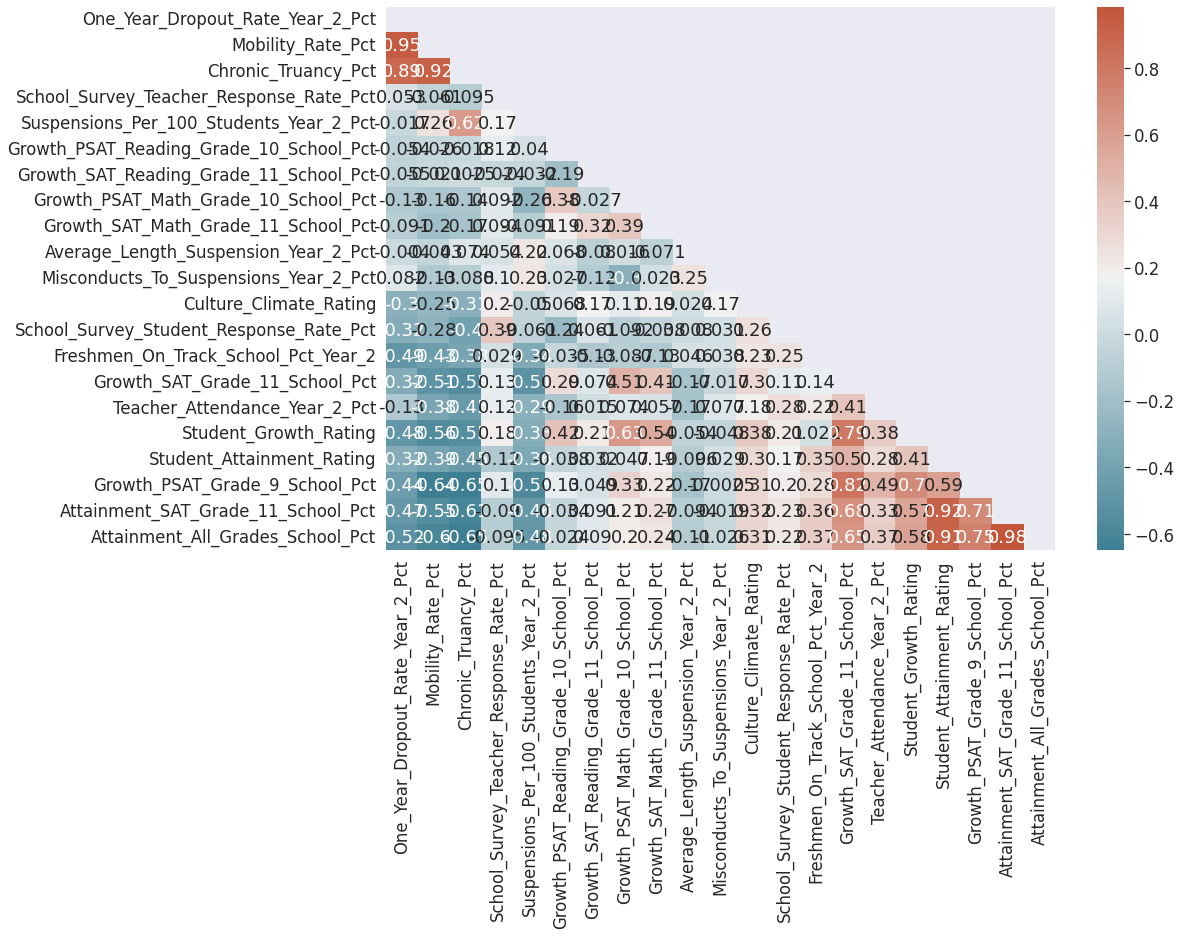

In [98]:
#Create Original Correlation Matrix
corr = high_schools[temp_cols].corr()
corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True)[0]

#Set correlation threshold
corr_thresh = .1

#Select, return, and add features to dataframe
select_features = [corr for corr in corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True) if abs(corr) >= corr_thresh]
return_features =  corr["Graduation_4_Year_School_Pct_Year_2"].sort_values(ascending = True)[0:len(select_features)]
to_dataframe = list(return_features.index)
new_df = high_schools[to_dataframe]

#Visualize the results
corr = high_schools[to_dataframe].corr()
plt.subplots(figsize=(15,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, mask=mask, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

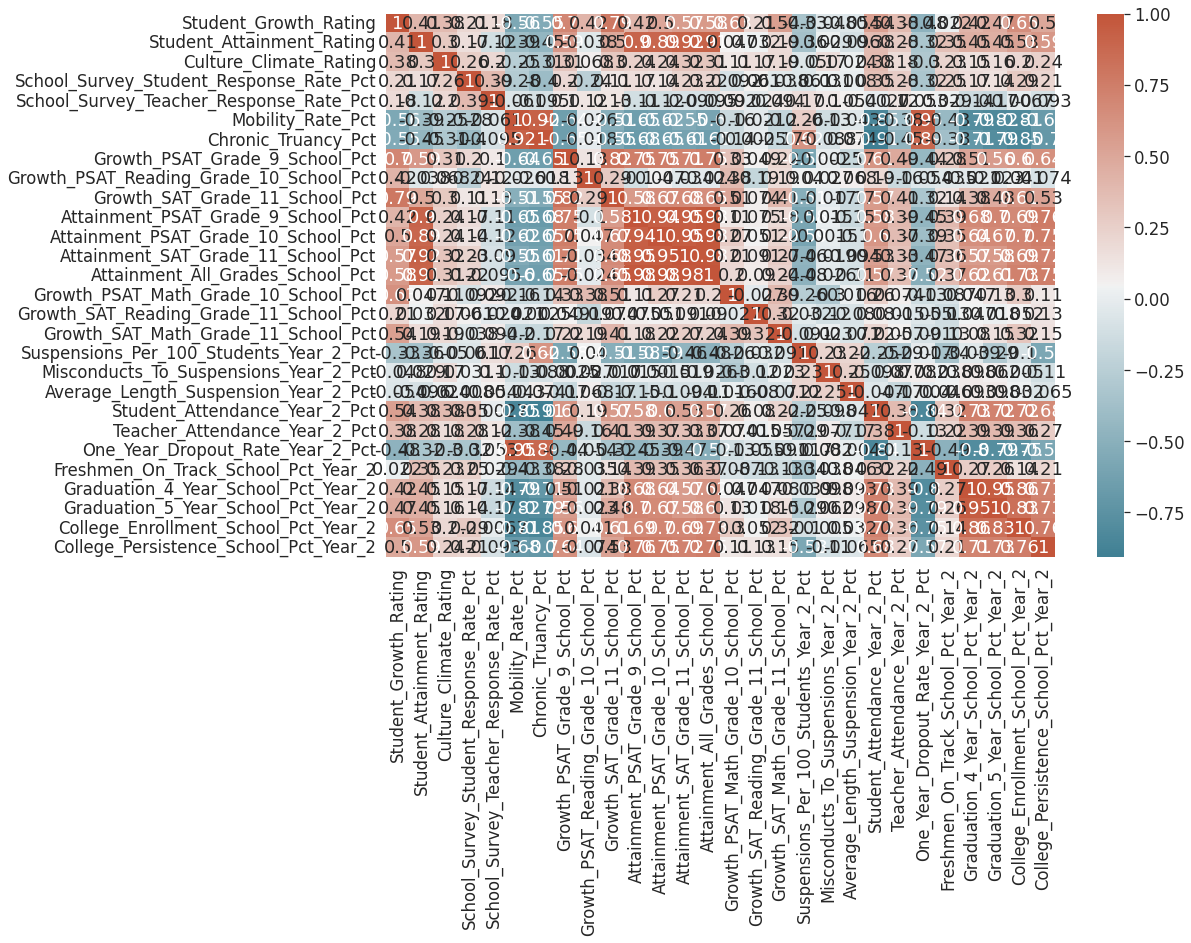

In [99]:
import matplotlib
corr = high_schools[temp_cols].corr()
matplotlib.pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [100]:
len(temp_cols)/len(high_schools)

0.26704545454545453

In [101]:
high_schools.drop(columns = temp_cols)

,Primary_Category,Address,City,State,Zip,Phone,Fax,CPS_School_Profile,Website,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Description,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,...,Freshmen_On_Track_CPS_Pct_Year_1,Graduation_4_Year_CPS_Pct_Year_2,Graduation_4_Year_School_Pct_Year_1,Graduation_4_Year_CPS_Pct_Year_1,Graduation_5_Year_CPS_Pct_Year_2,Graduation_5_Year_School_Pct_Year_1,Graduation_5_Year_CPS_Pct_Year_1,College_Enrollment_CPS_Pct_Year_2,College_Enrollment_School_Pct_Year_1,College_Enrollment_CPS_Pct_Year_1,College_Persistence_CPS_Pct_Year_2,College_Persistence_School_Pct_Year_1,College_Persistence_CPS_Pct_Year_1,Progress_Toward_Graduation_Year_1,State_School_Report_Card_URL,Empty_Progress_Report_Message,School_Survey_Rating_Description,Supportive_School_Award,Parent_Survey_Results_Year,School_Latitude,School_Longitude,PSAT_Grade_9_Score_School_Avg,PSAT_Grade_10_Score_School_Avg,SAT_Grade_11_Score_School_Avg,SAT_Grade_11_Score_CPS_Avg,Growth_PSAT_Grade_9_School_Lbl,Growth_PSAT_Reading_Grade_10_School_Lbl,Growth_SAT_Grade_11_School_Lbl,Attainment_PSAT_Grade_9_School_Lbl,Attainment_PSAT_Grade_10_School_Lbl,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Lbl,0,1,2,3,4
0,HS,9652 S MICHIGAN AVE,Chicago,Illinois,"60,628","7,735,355,400","7,735,355,061",http://cps.edu/Schools/Pages/school.aspx?Schoo...,https://www.harlanfalcons.org,"2,018",NaN,NaN,NaN,NaN,NaN,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,Results are based on student and teacher respo...,81.4,79.9,35.6,Not Achieved,Students learn better at healthy schools! This...,This school is Strong in the arts. It nearly m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.7,75.6,62.1,74.7,78.2,57.4,77.5,68.2,38.3,59.8,72.3,56.9,71.9,"2,017",http://iirc.niu.edu/School.aspx?schoolid=15016...,NaN,This school is “Partially Organized for Improv...,EMERGING,"2,018",41.718372,-87.620623,701,733,824,969.0,2nd,32nd,9th,8.3,4.8,5.6,6.2,7th,50th,50th,2.0,4.00,2.00,2.00,2.00
1,HS,3545 W FULTON BLVD,Chicago,Illinois,"60,624","7,735,346,755","7,735,346,938",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://www.alraby.org/,"2,018",NaN,NaN,NaN,NaN,NaN,Student Growth measures the change in standard...,NaN,NaN,NaN,NaN,Student Attainment measures how well the schoo...,NaN,NaN,NaN,NaN,Results are based on student and teacher respo...,81.4,79.9,35.6,Not Achieved,Students learn better at healthy schools! This...,This school is Developing in the arts. It occa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.7,75.6,58.8,74.7,78.2,67.5,77.5,68.2,37.1,59.8,72.3,51.1,71.9,"2,017",http://iirc.niu.edu/School.aspx?schoolid=15016...,NaN,This school is “Well-Organized for Improvement...,ESTABLISHED,"2,018",41.886210,-87.715423,685,756,814,969.0,1st,68th,3rd,4.8,0.0,3.5,2.7,16th,50th,63rd,3.0,4.00,4.00,4.00,2.00
2,HS,7740 S INGLESIDE AVE,Chicago,Illinois,"60,619","7,735,353,100","7,735,353,240",http://cps.edu/Schools/Pages/school.aspx?Schoo...,http://hir

In [102]:
def col_info(df, min=0, max=1):
    cols = df.columns[min:max]
    print(df.head().T[min:max] )
    return cols

In [103]:
col_info(high_schools, 0, 35)

                                                                                             0  ...                                                  4
School_ID                                                                              609,710  ...                                            610,389
Short_Name                                                                           HARLAN HS  ...                                             ORR HS
Long_Name                                          John M Harlan Community Academy High School  ...                            Orr Academy High School
School_Type                                                                       Neighborhood  ...                                       Neighborhood
Primary_Category                                                                            HS  ...                                                 HS
Address                                                                    9652 S MICHIGAN AVE

Index(['School_ID', 'Short_Name', 'Long_Name', 'School_Type',
       'Primary_Category', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax',
       'CPS_School_Profile', 'Website', 'Progress_Report_Year',
       'Blue_Ribbon_Award_Year', 'Excelerate_Award_Gold_Year',
       'Spot_Light_Award_Year', 'Improvement_Award_Year',
       'Excellence_Award_Year', 'Student_Growth_Rating',
       'Student_Growth_Description', 'Growth_Reading_Grades_Tested_Pct_ES',
       'Growth_Reading_Grades_Tested_Label_ES',
       'Growth_Math_Grades_Tested_Pct_ES',
       'Growth_Math_Grades_Tested_Label_ES', 'Student_Attainment_Rating',
       'Student_Attainment_Description', 'Attainment_Reading_Pct_ES',
       'Attainment_Reading_Lbl_ES', 'Attainment_Math_Pct_ES',
       'Attainment_Math_Lbl_ES', 'Culture_Climate_Rating',
       'Culture_Climate_Description',
       'School_Survey_Student_Response_Rate_Pct',
       'School_Survey_Student_Response_Rate_Avg_Pct'],
      dtype='object')

In [104]:
#[item for item in high_schools if high_schools[item].sum()/len(high_schools) >= .50]

# Normalize/Standardize/Scale Data
Before moving to Machine Learning models, it's important to ensure that data is consistent and standardized here.

In [105]:
'''
from sklearn.preprocessing import StandardScaler
data = target_df
scaler = StandardScaler()
print(scaler.fit(target_df[['Suspensions_Per_100_Students_Year_2_Pct', 'Chronic_Truancy_Pct']]))
print(scaler.transform(target_df[['Suspensions_Per_100_Students_Year_2_Pct', 'Chronic_Truancy_Pct']]))
'''

"\nfrom sklearn.preprocessing import StandardScaler\ndata = target_df\nscaler = StandardScaler()\nprint(scaler.fit(target_df[['Suspensions_Per_100_Students_Year_2_Pct', 'Chronic_Truancy_Pct']]))\nprint(scaler.transform(target_df[['Suspensions_Per_100_Students_Year_2_Pct', 'Chronic_Truancy_Pct']]))\n"

# Machine Learning Models

In [106]:
target_df = high_schools[['School_ID',
                        'Short_Name',
                        'Long_Name',
                        'School_Type',
                        'Suspensions_Per_100_Students_Year_2_Pct',
                        'Average_Length_Suspension_Year_2_Pct', 
                        'Behavior_Discipline_Year_2', 
                        'Chronic_Truancy_Pct',
                        'One_Year_Dropout_Rate_Year_2_Pct', 
                        'School_Survey_Safety',
                        'Student_Attainment_Rating', 
                        'Graduation_4_Year_School_Pct_Year_2',
                        'Teacher_Attendance_Year_2_Pct',]]

target_df.reset_index(inplace=True)

In [107]:
target_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   index                                    176 non-null    int64  
 1   School_ID                                176 non-null    object 
 2   Short_Name                               176 non-null    object 
 3   Long_Name                                176 non-null    object 
 4   School_Type                              176 non-null    object 
 5   Suspensions_Per_100_Students_Year_2_Pct  104 non-null    float64
 6   Average_Length_Suspension_Year_2_Pct     176 non-null    float64
 7   Behavior_Discipline_Year_2               172 non-null    object 
 8   Chronic_Truancy_Pct                      152 non-null    float64
 9   One_Year_Dropout_Rate_Year_2_Pct         169 non-null    float64
 10  School_Survey_Safety                     172 non-n

In [108]:
target_df.fillna(target_df.mean())

,index,School_ID,Short_Name,Long_Name,School_Type,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Behavior_Discipline_Year_2,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,School_Survey_Safety,Student_Attainment_Rating,Graduation_4_Year_School_Pct_Year_2,Teacher_Attendance_Year_2_Pct
0,0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,38.800000,2.100000,"2,017",89.400000,9.900000,WEAK,2,56.100000,93.300000
1,1,"610,334",RABY HS,Al Raby High School,Small,34.000000,2.000000,"2,017",85.700000,2.200000,WEAK,2,68.500000,95.000000
2,2,"609,712",HIRSCH HS,Emil G Hirsch Metropolitan High School,Neighborhood,40.600000,2.500000,"2,017",100.800000,14.100000,NEUTRAL,2,55.000000,94.100000
3,3,"610,543",SOLORIO HS,Eric Solorio Academy High School,Neighborhood,3.900000,2.000000,"2,017",34.100000,3.400000,WEAK,3,84.400000,95.900000
4,4,"610,389",ORR HS,Orr Academy High School,Neighborhood,20.500000,2.200000,"2,017",112.100000,18.200000,WEAK,2,30.300000,94.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,"610,383",SOCIAL JUSTICE HS,Greater Lawndale High School For Social Justice,Small,16.500000,2.200000,"2,017",50.500000,1.900000,VERY WEAK,2,86.000000,94.300000
172,172,"400,142",YCCS - VIRTUAL,YCCS-Virtual HS,Charter,13.955769,2.125962,"2,017",70.577632,9.294675,NOT ENOUGH DATA,2,69.865714,94.713043
173,173,"609,723",MARSHALL HS,John Marshall Metropolitan High School,Neighborhood,75.800000,2.500000,"2,017",120.300000,8.300000,NEUTRAL,2,62.800000,93.900000
174,174,"400,136",YCCS - OLIVE HARVEY,YCCS-Olive Harvey Middle College HS,Charter,13.955769,2.125962,"2,017",166.800000,40.400000,WEAK,2,69.865714,94.713043


In [109]:
#What are the types of data in these predictor columns
target_df.dtypes

index                                        int64
School_ID                                   object
Short_Name                                  object
Long_Name                                   object
School_Type                                 object
Suspensions_Per_100_Students_Year_2_Pct    float64
Average_Length_Suspension_Year_2_Pct       float64
Behavior_Discipline_Year_2                  object
Chronic_Truancy_Pct                        float64
One_Year_Dropout_Rate_Year_2_Pct           float64
School_Survey_Safety                        object
Student_Attainment_Rating                    int64
Graduation_4_Year_School_Pct_Year_2        float64
Teacher_Attendance_Year_2_Pct              float64
dtype: object

In [110]:
target_df['Suspensions_Per_100_Students_Year_2_Pct'].value_counts()

5.9     3
0.0     3
2.6     2
1.9     2
0.1     2
       ..
3.9     1
40.6    1
21.7    1
12.1    1
34.0    1
Name: Suspensions_Per_100_Students_Year_2_Pct, Length: 91, dtype: int64

In [111]:
target_df

,index,School_ID,Short_Name,Long_Name,School_Type,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Behavior_Discipline_Year_2,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,School_Survey_Safety,Student_Attainment_Rating,Graduation_4_Year_School_Pct_Year_2,Teacher_Attendance_Year_2_Pct
0,0,"609,710",HARLAN HS,John M Harlan Community Academy High School,Neighborhood,38.8,2.100000,"2,017",89.4,9.9,WEAK,2,56.1,93.3
1,1,"610,334",RABY HS,Al Raby High School,Small,34.0,2.000000,"2,017",85.7,2.2,WEAK,2,68.5,95.0
2,2,"609,712",HIRSCH HS,Emil G Hirsch Metropolitan High School,Neighborhood,40.6,2.500000,"2,017",100.8,14.1,NEUTRAL,2,55.0,94.1
3,3,"610,543",SOLORIO HS,Eric Solorio Academy High School,Neighborhood,3.9,2.000000,"2,017",34.1,3.4,WEAK,3,84.4,95.9
4,4,"610,389",ORR HS,Orr Academy High School,Neighborhood,20.5,2.200000,"2,017",112.1,18.2,WEAK,2,30.3,94.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,"610,383",SOCIAL JUSTICE HS,Greater Lawndale High School For Social Justice,Small,16.5,2.200000,"2,017",50.5,1.9,VERY WEAK,2,86.0,94.3
172,172,"400,142",YCCS - VIRTUAL,YCCS-Virtual HS,Charter,NaN,2.125962,"2,017",NaN,NaN,NOT ENOUGH DATA,2,NaN,NaN
173,173,"609,723",MARSHALL HS,John Marshall Metropolitan High School,Neighborhood,75.8,2.500000,"2,017",120.3,8.3,NEUTRAL,2,62.8,93.9
174,174,"400,136",YCCS - OLIVE HARVEY,YCCS-Olive Harvey Middle College HS,Charter,NaN,2.125962,"2,017",166.8,40.4,WEAK,2,NaN,NaN


In [112]:
target_df['Student_Attainment_Rating'].value_counts()

2    133
3     23
4     12
5      8
Name: Student_Attainment_Rating, dtype: int64

In [113]:
expec = []

for elem in target_df['Student_Attainment_Rating']:
    if elem == 'FAR BELOW EXPECTATIONS':
        expec.append(0)
    elif elem == 'BELOW EXPECTATIONS':
        expec.append(1)
    elif elem == 'MET EXPECTATIONS':
        expec.append(2)
    elif elem == 'ABOVE EXPECTATIONS':
        expec.append(3)
    elif elem == 'FAR ABOVE EXPECTATIONS':
        expec.append(4)
    elif elem == 'NO DATA AVAILABLE':
        expec.append(2)
    else:
        expec.append(2)

In [114]:
target_df['Student_Attainment_Numeric'] = expec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
df.columns[0:13]

Index(['School_ID', 'Short_Name', 'Long_Name', 'School_Type',
       'Primary_Category', 'Address', 'City', 'State', 'Zip', 'Phone', 'Fax',
       'CPS_School_Profile', 'Website'],
      dtype='object')

In [116]:
np.mean(target_df['Graduation_4_Year_School_Pct_Year_2'])

69.86571428571426

In [117]:
target_df['Meeting_Graduation_Rates'] = [1 if elem >= 85 else 0 for elem in target_df.Graduation_4_Year_School_Pct_Year_2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [118]:
target_df.corr()

,index,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Student_Attainment_Rating,Graduation_4_Year_School_Pct_Year_2,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
index,1.000000,0.028288,-0.153740,-0.083496,-0.089519,0.170162,-0.012145,0.019612,NaN,0.018853
Suspensions_Per_100_Students_Year_2_Pct,0.028288,1.000000,0.222558,0.618375,-0.017099,-0.357907,-0.039183,-0.293467,NaN,-0.255595
Average_Length_Suspension_Year_2_Pct,-0.153740,0.222558,1.000000,0.074186,-0.004034,-0.096322,0.093055,-0.174772,NaN,-0.011001
Chronic_Truancy_Pct,-0.083496,0.618375,0.074186,1.000000,0.887752,-0.451539,-0.713193,-0.453415,NaN,-0.385091
One_Year_Dropout_Rate_Year_2_Pct,-0.089519,-0.017099,-0.004034,0.887752,1.000000,-0.322651,-0.795938,-0.131236,NaN,-0.332780
Student_Attainment_Rating,0.170162,-0.357907,-0.096322,-0.451539,-0.322651,1.000000,0.451955,0.282159,NaN,0.585003
Graduation_4_Year_School_Pct_Year_2,-0.012145,-0.039183,0.093055,-0.713193,-0.795938,0.451955,1.000000,0.388617,NaN,0.523175
Teacher_Attendance_Year_2_Pct,0.019612,-0.293467,-0.174772,-0.453415,-0.131236,0.282159,0.388617,1.000000,NaN,0.230836
Student_Attainment_Numeric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Meeting_Graduation_Rates,0.018853,-0.255595,-0.011001,-0.385091,-0.332780,0.585003,0.523175,0.230836,NaN,1.000000


In [119]:
f_target_df = target_df[['Suspensions_Per_100_Students_Year_2_Pct', 'Average_Length_Suspension_Year_2_Pct', 'Chronic_Truancy_Pct', 'One_Year_Dropout_Rate_Year_2_Pct', 'Teacher_Attendance_Year_2_Pct',  'Student_Attainment_Numeric', 'Meeting_Graduation_Rates']]
target = target_df['Meeting_Graduation_Rates']

In [120]:
X = f_target_df.drop(['Meeting_Graduation_Rates', 'Average_Length_Suspension_Year_2_Pct'], axis = 1).fillna(f_target_df.mean())
y = f_target_df['Meeting_Graduation_Rates']

In [121]:
len(f_target_df)

176

In [122]:
#Target DF
#f_target_df['Average_Length_Suspension_Year_2_Pct'] = [(elem.split(" ")[0]) for elem in f_target_df['Average_Length_Suspension_Year_2_Pct']]

In [123]:
#Impute for suspension length, year 2
try:
    f_target_df['Average_Length_Suspension_Year_2_Pct'] = [float(elem[0:3]) for elem in f_target_df['Average_Length_Suspension_Year_2_Pct']]
except:
    print("(Already Casted as int)")

(Already Casted as int)


In [124]:
f_target_df.dtypes[f_target_df.columns[0:-1]]

Suspensions_Per_100_Students_Year_2_Pct    float64
Average_Length_Suspension_Year_2_Pct       float64
Chronic_Truancy_Pct                        float64
One_Year_Dropout_Rate_Year_2_Pct           float64
Teacher_Attendance_Year_2_Pct              float64
Student_Attainment_Numeric                   int64
dtype: object

In [125]:
f_target_df

,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
0,38.8,2.100000,89.4,9.9,93.3,2,0
1,34.0,2.000000,85.7,2.2,95.0,2,0
2,40.6,2.500000,100.8,14.1,94.1,2,0
3,3.9,2.000000,34.1,3.4,95.9,2,0
4,20.5,2.200000,112.1,18.2,94.3,2,0
...,...,...,...,...,...,...,...
171,16.5,2.200000,50.5,1.9,94.3,2,1
172,NaN,2.125962,NaN,NaN,NaN,2,0
173,75.8,2.500000,120.3,8.3,93.9,2,0
174,NaN,2.125962,166.8,40.4,NaN,2,0


In [126]:
#SK Learn
import sklearn
from sklearn.preprocessing import StandardScaler

X_features = X
X = StandardScaler().fit_transform(X)

#Model Comparison
This will attempt to learn from classification, etc.

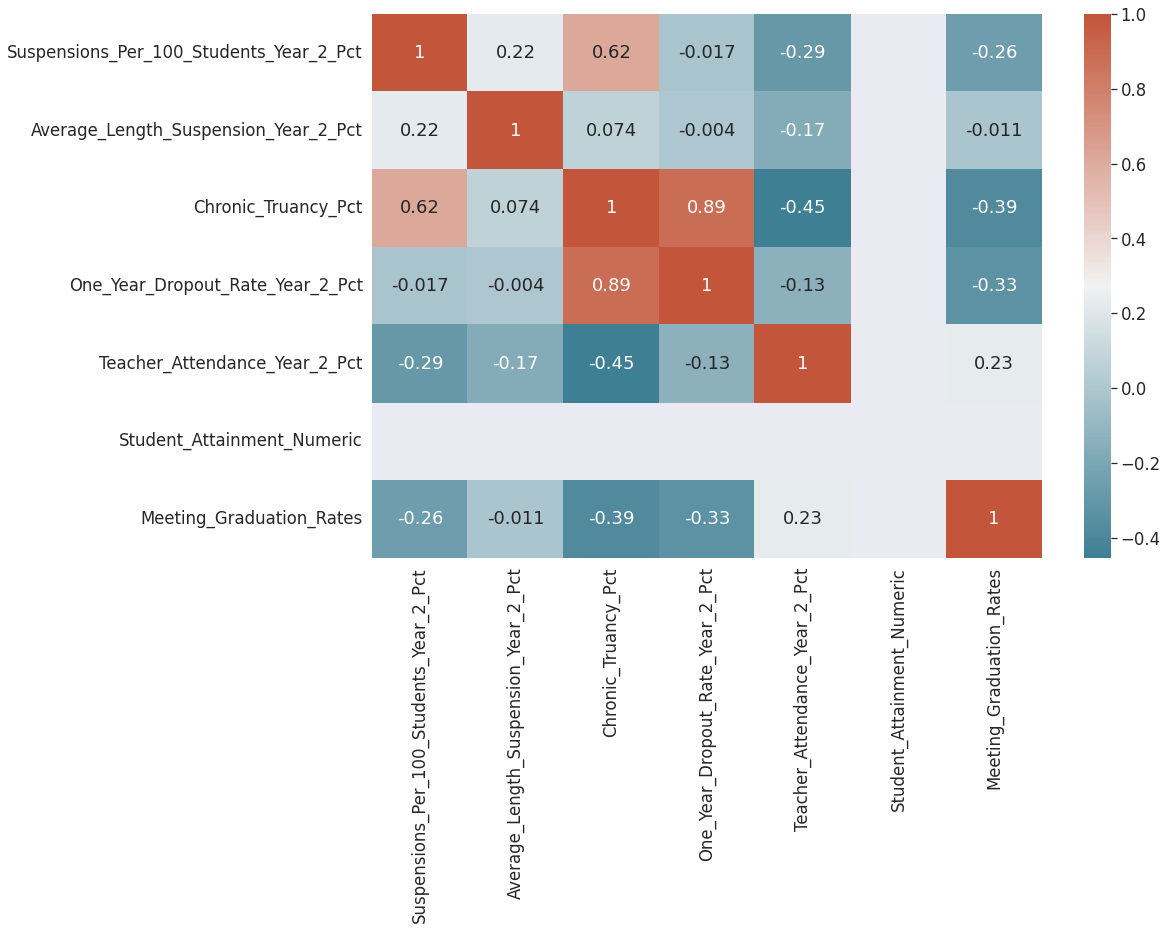

In [127]:
import matplotlib
corr = f_target_df.corr()
matplotlib.pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [129]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

model1 = DecisionTreeClassifier(random_state=1)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.57      0.33      0.42        12

    accuracy                           0.75        44
   macro avg       0.68      0.62      0.63        44
weighted avg       0.73      0.75      0.73        44



In [130]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        32
           1       0.67      0.33      0.44        12

    accuracy                           0.77        44
   macro avg       0.73      0.64      0.65        44
weighted avg       0.76      0.77      0.74        44



In [131]:
from sklearn.ensemble import AdaBoostClassifier
model3 = AdaBoostClassifier(random_state=1)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.62      0.42      0.50        12

    accuracy                           0.77        44
   macro avg       0.72      0.66      0.68        44
weighted avg       0.76      0.77      0.76        44



In [132]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier(random_state=1)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.56      0.42      0.48        12

    accuracy                           0.75        44
   macro avg       0.68      0.65      0.66        44
weighted avg       0.73      0.75      0.74        44



In [133]:
y_pred4

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0])

In [134]:
import xgboost as xgb
model5 = xgb.XGBClassifier(random_state=1)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.60      0.50      0.55        12

    accuracy                           0.77        44
   macro avg       0.71      0.69      0.70        44
weighted avg       0.76      0.77      0.77        44



In [135]:
# Filtering df for only good quality
df_temp = f_target_df[f_target_df['Meeting_Graduation_Rates']==1]
df_temp.describe()

,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
count,29.000000,36.000000,36.000000,36.000000,26.000000,36.0,36.0
mean,7.531034,2.113381,39.005556,0.944444,95.061538,2.0,1.0
std,8.163818,0.503368,18.723613,0.746207,0.780808,0.0,0.0
min,0.100000,1.000000,1.800000,0.100000,94.000000,2.0,1.0
25%,1.900000,1.850000,25.950000,0.400000,94.550000,2.0,1.0
50%,4.000000,2.125962,39.500000,0.700000,94.900000,2.0,1.0
75%,8.800000,2.325000,53.775000,1.225000,95.475000,2.0,1.0
max,32.500000,3.100000,82.900000,3.300000,96.900000,2.0,1.0


In [136]:
# Filtering df for only bad quality
df_temp2 = f_target_df[f_target_df['Meeting_Graduation_Rates']==0]
df_temp2.describe()

,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
count,75.000000,140.000000,116.000000,133.000000,66.000000,140.0,140.0
mean,16.440000,2.129196,80.375862,11.554887,94.575758,2.0,0.0
std,17.196103,0.601583,47.345835,13.924251,0.984192,0.0,0.0
min,0.000000,0.000000,3.000000,0.200000,92.600000,2.0,0.0
25%,4.650000,2.000000,45.475000,2.000000,93.925000,2.0,0.0
50%,10.300000,2.125962,69.900000,4.700000,94.450000,2.0,0.0
75%,22.050000,2.125962,97.250000,13.300000,95.175000,2.0,0.0
max,75.800000,4.100000,199.400000,47.000000,96.600000,2.0,0.0


In [137]:
#Clustering
f_target_df.head()

,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
0,38.8,2.1,89.4,9.9,93.3,2,0
1,34.0,2.0,85.7,2.2,95.0,2,0
2,40.6,2.5,100.8,14.1,94.1,2,0
3,3.9,2.0,34.1,3.4,95.9,2,0
4,20.5,2.2,112.1,18.2,94.3,2,0


In [138]:
show_nulls(f_target_df['Student_Attainment_Numeric'])

[0, 0.0]

In [139]:
f_target_df

,Suspensions_Per_100_Students_Year_2_Pct,Average_Length_Suspension_Year_2_Pct,Chronic_Truancy_Pct,One_Year_Dropout_Rate_Year_2_Pct,Teacher_Attendance_Year_2_Pct,Student_Attainment_Numeric,Meeting_Graduation_Rates
0,38.8,2.100000,89.4,9.9,93.3,2,0
1,34.0,2.000000,85.7,2.2,95.0,2,0
2,40.6,2.500000,100.8,14.1,94.1,2,0
3,3.9,2.000000,34.1,3.4,95.9,2,0
4,20.5,2.200000,112.1,18.2,94.3,2,0
...,...,...,...,...,...,...,...
171,16.5,2.200000,50.5,1.9,94.3,2,1
172,NaN,2.125962,NaN,NaN,NaN,2,0
173,75.8,2.500000,120.3,8.3,93.9,2,0
174,NaN,2.125962,166.8,40.4,NaN,2,0


In [140]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.datasets import make_blobs


from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score, completeness_score, homogeneity_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

In [141]:
f_target_df.columns

Index(['Suspensions_Per_100_Students_Year_2_Pct',
       'Average_Length_Suspension_Year_2_Pct', 'Chronic_Truancy_Pct',
       'One_Year_Dropout_Rate_Year_2_Pct', 'Teacher_Attendance_Year_2_Pct',
       'Student_Attainment_Numeric', 'Meeting_Graduation_Rates'],
      dtype='object')

In [142]:
km_cluster = KMeans(3, random_state=9) # We know there are 3 class labels, lets see how well we can seperate them with clustering

In [143]:
km_clusters = km_cluster.fit_predict(f_target_df.drop('One_Year_Dropout_Rate_Year_2_Pct',axis=1))

ValueError: ignored

In [ ]:
km_clusters

In [ ]:
print("Homogeneity", homogeneity_score(f_target_df['One_Year_Dropout_Rate_Year_2_Pct'], km_clusters) ) 
print("Completeness", completeness_score(f_target_df['One_Year_Dropout_Rate_Year_2_Pct'], km_clusters) ) 
print("V-Score", v_measure_score(f_target_df['One_Year_Dropout_Rate_Year_2_Pct'], km_clusters) ) 